This notebook is meant to be run in Google Colab, please upload the data files before running

# Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Read the datasets

In [2]:
# path to the files
attacks_path = '/content/ddos_data.attacks.anonimized.csv'
vectors_path = '/content/ddos_data.vectors.anonimized.csv'

In [104]:
attack_df = pd.read_csv(attacks_path)
attack_df.head()

,Attack ID,Card,Victim IP,Port number,Attack code,Detect count,Significant flag,Packet speed,Data speed,Avg packet len,Avg source IP count,Start time,End time,Whitelist flag,Type
0,1,sga10gq0,IP_0001,4500,High volume traffic,1,0,55600,73,1383,6,2022-08-08T18:09:36,2022-08-08T18:09:37,0,Normal traffic
1,2,sga10gq0,IP_0002,4500,High volume traffic,1,0,63500,90,1506,1,2022-08-08T18:37:28,2022-08-08T18:37:28,0,Normal traffic
2,3,sga10gq0,IP_0003,1200,High volume traffic,2,0,62700,82,1399,1,2022-08-08T18:41:25,2022-08-08T18:41:26,0,Normal traffic
3,4,sga10gq0,IP_0002,4500,High volume traffic,1,0,59500,85,1486,1,2022-08-08T18:47:49,2022-08-08T18:47:50,0,Normal traffic
4,5,sga10gq0,IP_0004,12347,High volume traffic,2,1,78250,113,1518,1,2022-08-08T18:57:15,2022-08-08T18:58:11,0,Normal traffic


In [4]:
vector_df = pd.read_csv(vectors_path)
vector_df.head()

,Attack ID,Detect count,Card,Victim IP,Port number,Attack code,Significant flag,Packet speed,Data speed,Avg packet len,Source IP count,Time
0,1,1,sga10gq0,IP_0001,4500,High volume traffic,0,55600,73,1383,6,2022-08-08T18:09:36
1,2,1,sga10gq0,IP_0002,4500,High volume traffic,0,63500,90,1506,1,2022-08-08T18:37:28
2,3,1,sga10gq0,IP_0003,1200,High volume traffic,0,59700,79,1399,1,2022-08-08T18:41:25
3,3,2,sga10gq0,IP_0003,1200,High volume traffic,0,65700,86,1399,1,2022-08-08T18:41:26
4,4,1,sga10gq0,IP_0002,4500,High volume traffic,0,59500,85,1486,1,2022-08-08T18:47:49


# Attacks dataframe

Normal traffic        124137
Suspicious traffic      9707
DDoS attack              926
Name: Type, dtype: int64


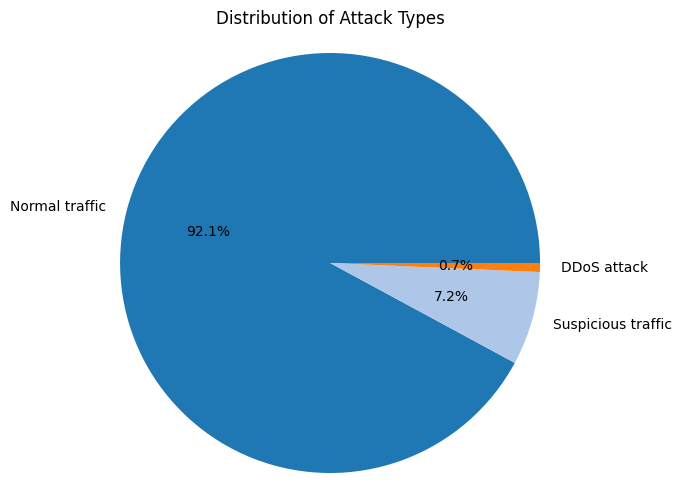

In [5]:
# see how many records are in different classes
value_counts = attack_df['Type'].value_counts()
labels = value_counts.index
print(value_counts)

# Plot
plt.figure(figsize=(8, 6))
plt.pie(value_counts.values, labels = value_counts.index,  autopct='%1.1f%%', colors = plt.cm.tab20.colors)
plt.axis('equal')
plt.title("Distribution of Attack Types")

plt.show()

## Attack labels

In [6]:
# see how many records are with different attack codes of not normal traffic
value_counts = attack_df['Attack code'].value_counts()
print(value_counts)

High volume traffic                                                             124137
Suspicious traffic                                                                6567
Suspicious traffic, High volume traffic                                           3140
SYN Attack                                                                         246
DNS                                                                                129
Generic UDP                                                                        122
Generic UDP, Suspicious traffic                                                     96
Generic UDP, High volume traffic                                                    75
CLDAP, High volume traffic                                                          49
NTP                                                                                 34
CLDAP                                                                               22
Suspicious traffic, DNS, High volume traffi

In [7]:
# there are multiple labels on some attacks
# get all the labels
attack_labels_mixed = list(value_counts.index)
attack_labels = []
for mixed_label in attack_labels_mixed:
  for label in mixed_label.split(','):
    attack_labels.append(label.strip())
# get the distinct labels
attack_labels = list(set(attack_labels))
attack_labels

['DNS',
 'High volume traffic',
 'Sentinel',
 'IPv4 fragmentation',
 'SNMP',
 'RPC',
 'SYN Attack',
 'NTP',
 'Suspicious traffic',
 'Generic UDP',
 'CLDAP',
 'CoAP',
 'TCP Anomaly',
 'ACK Attack',
 'CHARGEN',
 'RDP',
 'SSDP']

These can be one-hot-encoded, however this is not neccessary for the data analysis

In [8]:
# count attacks for each label
label_count = {}
for label in attack_labels:
  count = attack_df['Attack code'].str.contains(label, case=False).sum()
  label_count[label] = count

# add all attack count
label_count['All attacks'] = len(attack_df)

# order the dict by frequency
label_count = dict(sorted(label_count.items(),key=lambda item: item[1], reverse = True))

for l, c in label_count.items():
  print(f"{l} : {c}")

All attacks : 134770
High volume traffic : 127489
Suspicious traffic : 9888
Generic UDP : 312
SYN Attack : 248
DNS : 176
CLDAP : 82
NTP : 71
IPv4 fragmentation : 23
CoAP : 11
TCP Anomaly : 11
SSDP : 9
Sentinel : 5
ACK Attack : 3
CHARGEN : 2
SNMP : 1
RPC : 1
RDP : 1


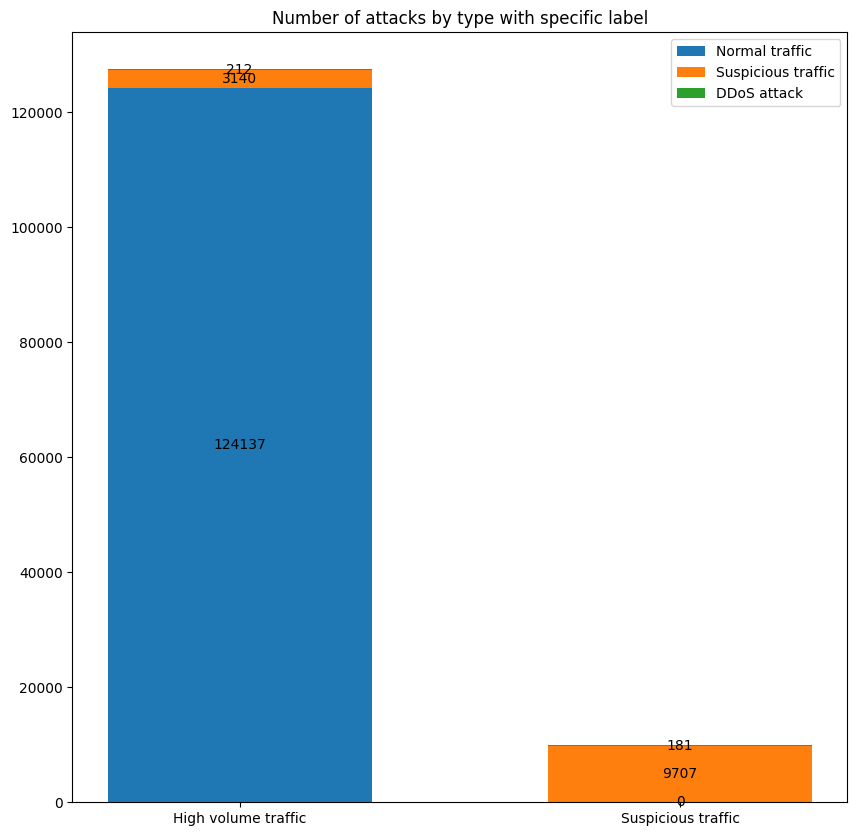

In [9]:
# lets check the class distribution for each label
# high volume and suspicious traffic are the most frequent lets check them seperately

# get the frequency of each class
attack_labels_to_plot = ('High volume traffic', 'Suspicious traffic')
num_attacks_by_type = {label: [] for label in labels}

for attack_label in attack_labels_to_plot:
  for k, _ in num_attacks_by_type.items():
    attack_label_df = attack_df[(attack_df['Attack code'].str.contains(attack_label, case=False))
                                & (attack_df['Type'] == k)]
    num_attacks_by_type[k].append(len(attack_label_df))

num_attacks_by_type

# plot it on a barplot
width = 0.6  # the width of the bars

fig, ax = plt.subplots(figsize=(10,10))
bottom = np.zeros(len(attack_labels_to_plot))

for label, count in num_attacks_by_type.items():
    p = ax.bar(attack_labels_to_plot, count, width, label=label, bottom=bottom)
    bottom += count

    ax.bar_label(p, label_type='center')

ax.set_title('Number of attacks by type with specific label')
ax.legend()

plt.show()

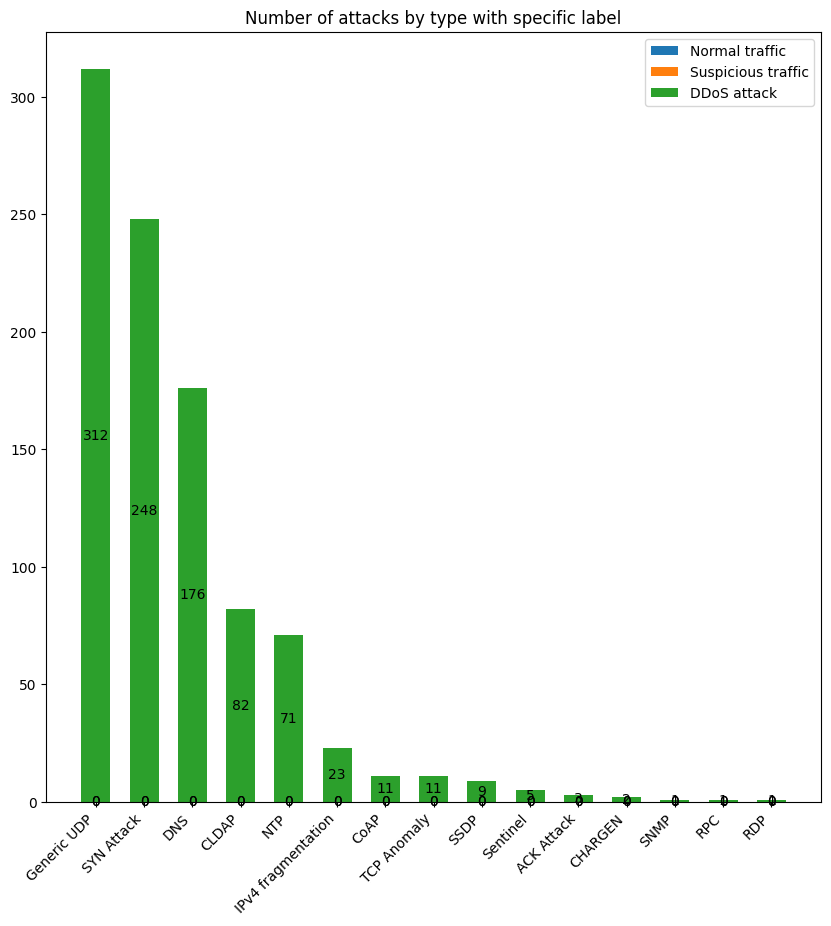

In [10]:
# check for the other labels
# lets check the class distribution for each label
# high volume and suspicious traffic are the most frequent lets check them seperately

# get the frequency of each class
attack_labels_to_plot = list(label_count.keys())[3:]
num_attacks_by_type = {label: [] for label in labels}

for attack_label in attack_labels_to_plot:
  for k, _ in num_attacks_by_type.items():
    attack_label_df = attack_df[(attack_df['Attack code'].str.contains(attack_label, case=False))
                                & (attack_df['Type'] == k)]
    num_attacks_by_type[k].append(len(attack_label_df))

num_attacks_by_type

# plot it on a barplot
width = 0.6  # the width of the bars

fig, ax = plt.subplots(figsize=(10,10))
bottom = np.zeros(len(attack_labels_to_plot))

for label, count in num_attacks_by_type.items():
    p = ax.bar(attack_labels_to_plot, count, width, label=label, bottom=bottom)
    bottom += count

    ax.bar_label(p, label_type='center')

ax.set_title('Number of attacks by type with specific label')
ax.legend()
plt.xticks(rotation=45, ha='right')
plt.show()

All of the attack labels with less frequency are indicative of a ddos attack.

## Numerical values analysis

In [11]:
# the number of unique values of each column
attack_df.nunique()

Attack ID              134770
Card                        1
Victim IP               18200
Port number             29624
Attack code                47
Detect count              461
Significant flag            2
Packet speed            16241
Data speed                606
Avg packet len           1269
Avg source IP count       315
Start time             127985
End time               127918
Whitelist flag              2
Type                        3
dtype: int64

## Port number


In [12]:
# Most frequent ports by label
for label in labels:
  print(f"Most frequent ports for {label}")
  print("port \t count")
  vc = attack_df[attack_df['Type'] == label]['Port number'].value_counts()
  print(vc[:5])
  print(f"There a {len(vc)} number of different ports for {label}")

Most frequent ports for Normal traffic
port 	 count
0        20411
4500     19757
80        6886
443       5665
60645     3686
Name: Port number, dtype: int64
There a 28703 number of different ports for Normal traffic
Most frequent ports for Suspicious traffic
port 	 count
0        868
34863    686
4500     187
51413    120
443      119
Name: Port number, dtype: int64
There a 5606 number of different ports for Suspicious traffic
Most frequent ports for DDoS attack
port 	 count
443      237
0        191
53       124
80       108
51413     66
Name: Port number, dtype: int64
There a 84 number of different ports for DDoS attack


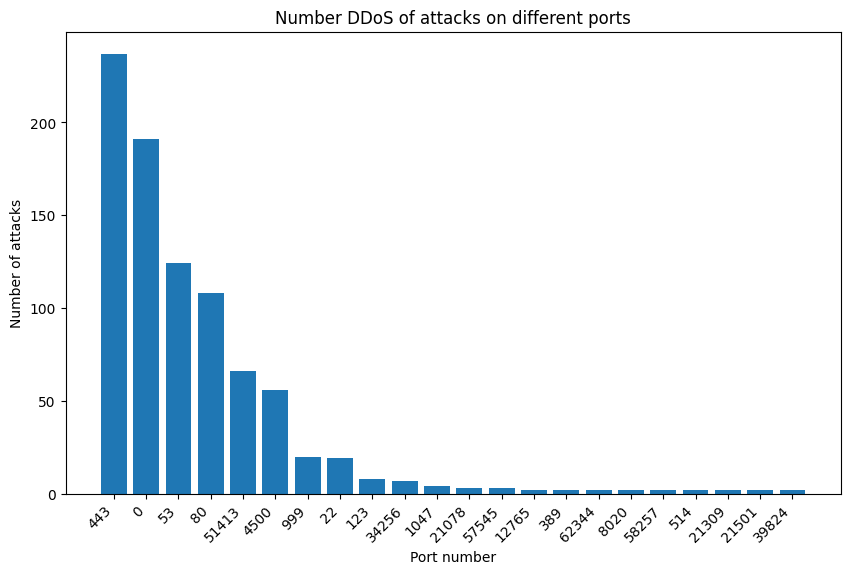

In [13]:
# create histogram for ports for ddos attacks with more than 1 attack
vc = attack_df[attack_df['Type'] == 'DDoS attack']['Port number'].value_counts()

plt.figure(figsize=(10,6))
plt.bar(np.arange(0, len(vc[vc > 1]), 1), vc[vc > 1].values, label = vc[vc>1].index)
plt.title('Number DDoS of attacks on different ports')
plt.xlabel('Port number')
plt.ylabel('Number of attacks')
plt.xticks(np.arange(0, len(vc[vc > 1]), 1), vc[vc > 1].index, rotation=45, ha='right')
plt.show()

There are a few special ports in the most frequent ones, lets see how many of them fall into the different types

In [14]:
attack_df[attack_df['Port number'] == 443]['Type'].value_counts().sort_index()

DDoS attack            237
Normal traffic        5665
Suspicious traffic     119
Name: Type, dtype: int64

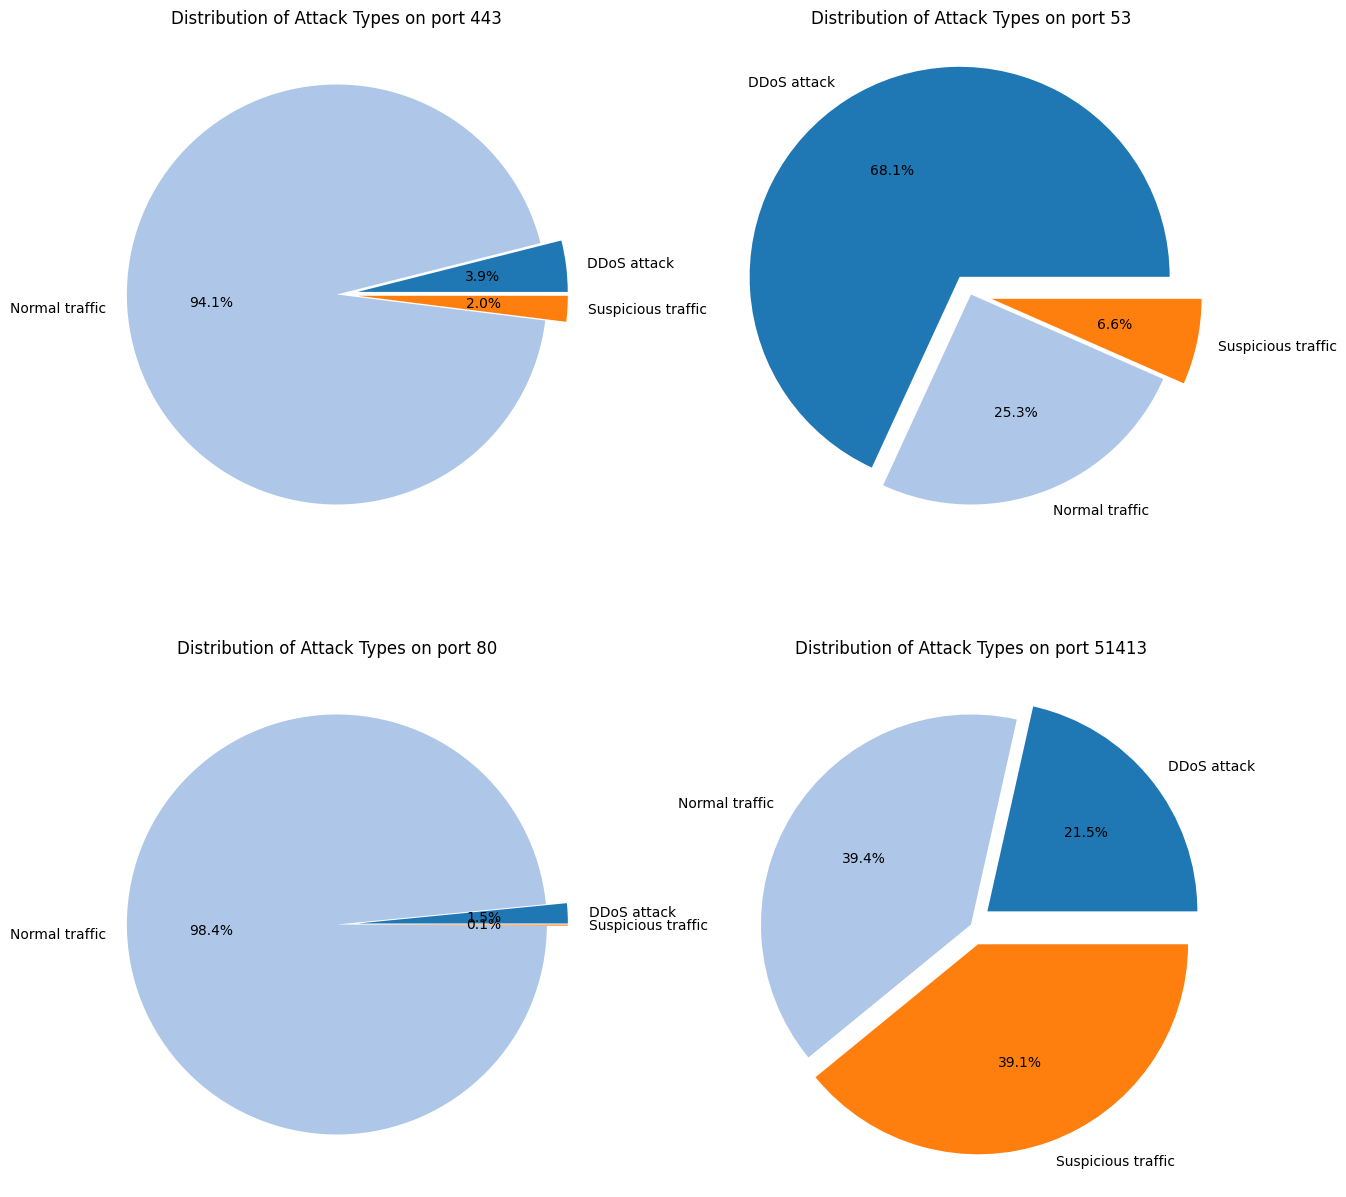

In [15]:
special_ports = [443, 53, 80, 51413]

fig, ax = plt.subplots(2,2, figsize=(15, 15))

for idx, port in enumerate(special_ports):
  vc = attack_df[attack_df['Port number'] == port]['Type'].value_counts().sort_index()
  explode = (0.1, 0, 0.1)

  ax[idx//2][idx%2].pie(vc.values, labels = vc.index,  autopct='%1.1f%%', colors = plt.cm.tab20.colors, explode = explode)
  ax[idx//2][idx%2].set_title(f"Distribution of Attack Types on port {port}")

## Packet speed, Data speed, Avg packet len, Avg source IP count

In [141]:
def calculate_zscores(df, col):
  mean = df[col].mean()
  std_dev = df[col].std()

  # Calculate Z-scores
  z_scores = (df[col] - mean) / std_dev

  return z_scores

In [146]:
def create_violin_plots(df, col, z_scores, threshold):
  # Plot the violin plot without the outliers
  plt.figure(figsize=(8, 6))

  # create a seperate plot for each class
  data = []
  for label in labels:
    data.append(df[(df['Type'] == label) & (z_scores <= threshold) & (z_scores >= -threshold)][col])
  # also for the whole dataset
  data.append(df[(z_scores <= threshold) & (z_scores >= -threshold)][col])

  # plot
  parts = plt.violinplot(data, showmeans = True, showextrema=True, showmedians=True)

  # Set the colors for the violins based on the category
  colors = ['Blue', 'Green', 'Purple', 'salmon']

  # Set the color of the violin patches
  for pc, color in zip(parts['bodies'], colors):
      pc.set_facecolor(color)

  # Create legend labels and handles for each violin plot
  legend_labels = list(labels)
  legend_labels.append('All data')
  legend_handles = [plt.Rectangle((0,0), 1, 1, color=color, edgecolor='black') for color in colors]

  # Plot settings
  plt.legend(legend_handles, legend_labels)
  plt.title(f'Violin plot of {col} by label')
  plt.ylabel('Values')
  plt.xlabel('Density')
  plt.grid(True)
  plt.show()

<ipython-input-146-d2af329cf88d>:25: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  legend_handles = [plt.Rectangle((0,0), 1, 1, color=color, edgecolor='black') for color in colors]


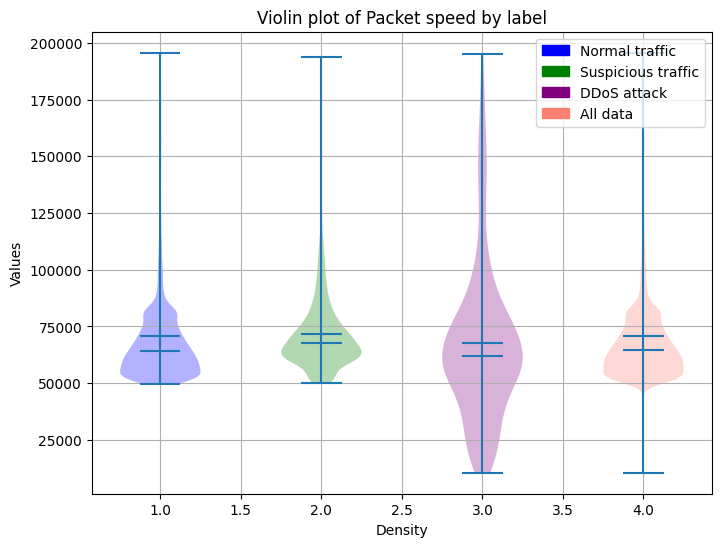

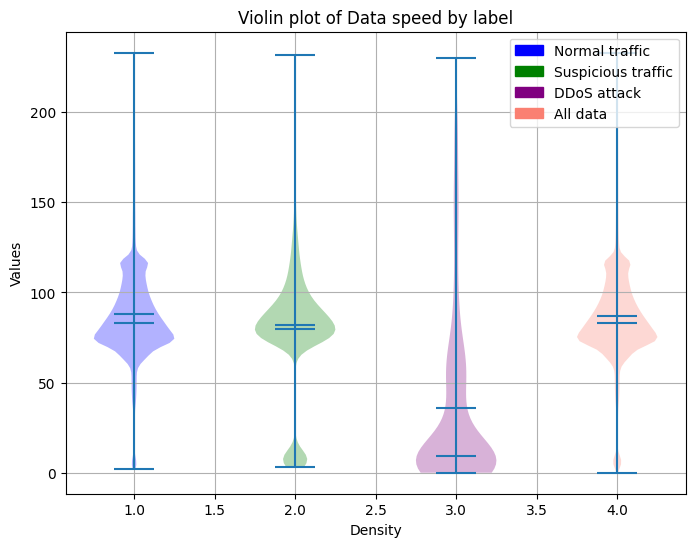

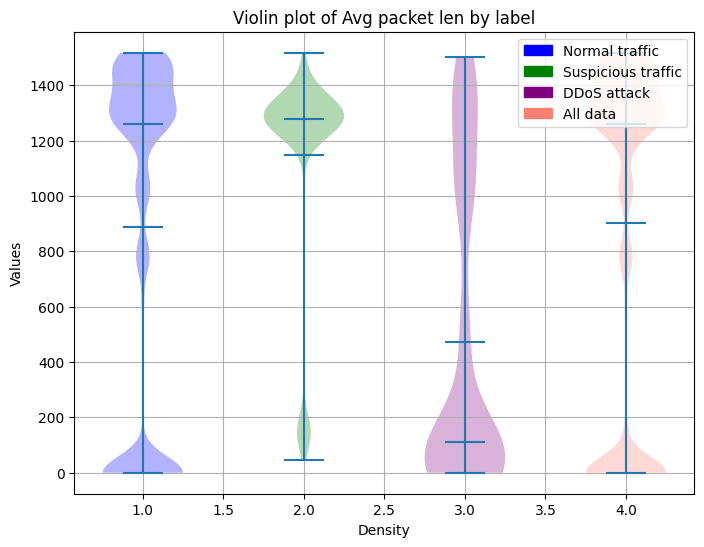

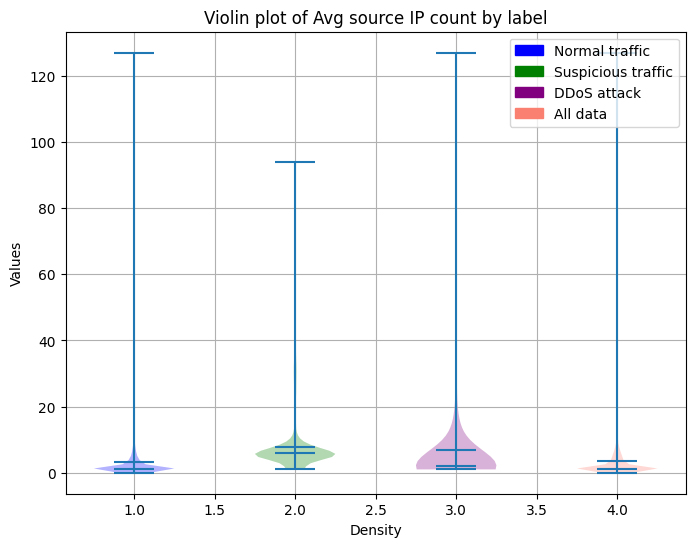

In [147]:
columns_to_plot = ['Packet speed', 'Data speed', 'Avg packet len', 'Avg source IP count']

for col in columns_to_plot:
  zscores = calculate_zscores(attack_df, col)
  create_violin_plots(attack_df, col, zscores, threshold = 3)

## Attack duration

In [106]:
# convert date columns
attack_df['Start time'] = pd.to_datetime(attack_df['Start time'].replace('0', np.nan), errors = 'coerce')
attack_df['End time'] = pd.to_datetime(attack_df['End time'].replace('0', np.nan), errors = 'coerce')
# drop NaN values
attack_df = attack_df.dropna(subset=['Start time', 'End time'])

In [113]:
# get attack duration

attack_df['Attack duration'] = attack_df['End time'] - attack_df['Start time']
attack_df['Attack duration'] = attack_df['Attack duration'].apply(lambda x: x.total_seconds())
attack_df['Attack duration'].describe()

<ipython-input-113-62c64a1c1e35>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  attack_df['Attack duration'] = attack_df['End time'] - attack_df['Start time']
<ipython-input-113-62c64a1c1e35>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  attack_df['Attack duration'] = attack_df['Attack duration'].apply(lambda x: x.total_seconds())


count    134766.000000
mean         30.398409
std         213.921084
min           0.000000
25%           1.000000
50%           1.000000
75%           5.000000
max       41009.000000
Name: Attack duration, dtype: float64

<ipython-input-117-e6751596ead5>:25: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  legend_handles = [plt.Rectangle((0,0), 1, 1, color=color, edgecolor='black') for color in colors]


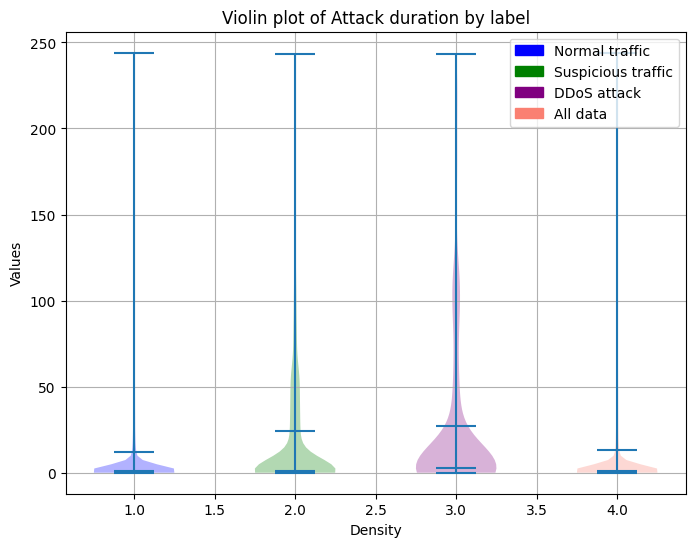

In [119]:
# plot
zscores = calculate_zscores(attack_df, 'Attack duration')
create_violin_plots(attack_df, 'Attack duration', zscores, threshold = 1)

# Vectors dataframe

In [121]:
vector_df.head()

,Attack ID,Detect count,Card,Victim IP,Port number,Attack code,Significant flag,Packet speed,Data speed,Avg packet len,Source IP count,Time
0,1,1,sga10gq0,IP_0001,4500,High volume traffic,0,55600,73,1383,6,2022-08-08T18:09:36
1,2,1,sga10gq0,IP_0002,4500,High volume traffic,0,63500,90,1506,1,2022-08-08T18:37:28
2,3,1,sga10gq0,IP_0003,1200,High volume traffic,0,59700,79,1399,1,2022-08-08T18:41:25
3,3,2,sga10gq0,IP_0003,1200,High volume traffic,0,65700,86,1399,1,2022-08-08T18:41:26
4,4,1,sga10gq0,IP_0002,4500,High volume traffic,0,59500,85,1486,1,2022-08-08T18:47:49


In [123]:
# add labels to the dataset
vector_df = pd.merge(vector_df, attack_df[['Attack ID', 'Type']], on='Attack ID', how='left')
vector_df.head()

,Attack ID,Detect count,Card,Victim IP,Port number,Attack code,Significant flag,Packet speed,Data speed,Avg packet len,Source IP count,Time,Type
0,1,1,sga10gq0,IP_0001,4500,High volume traffic,0,55600,73,1383,6,2022-08-08T18:09:36,Normal traffic
1,2,1,sga10gq0,IP_0002,4500,High volume traffic,0,63500,90,1506,1,2022-08-08T18:37:28,Normal traffic
2,3,1,sga10gq0,IP_0003,1200,High volume traffic,0,59700,79,1399,1,2022-08-08T18:41:25,Normal traffic
3,3,2,sga10gq0,IP_0003,1200,High volume traffic,0,65700,86,1399,1,2022-08-08T18:41:26,Normal traffic
4,4,1,sga10gq0,IP_0002,4500,High volume traffic,0,59500,85,1486,1,2022-08-08T18:47:49,Normal traffic


Normal traffic        187330
Suspicious traffic     34536
DDoS attack            31172
Name: Type, dtype: int64


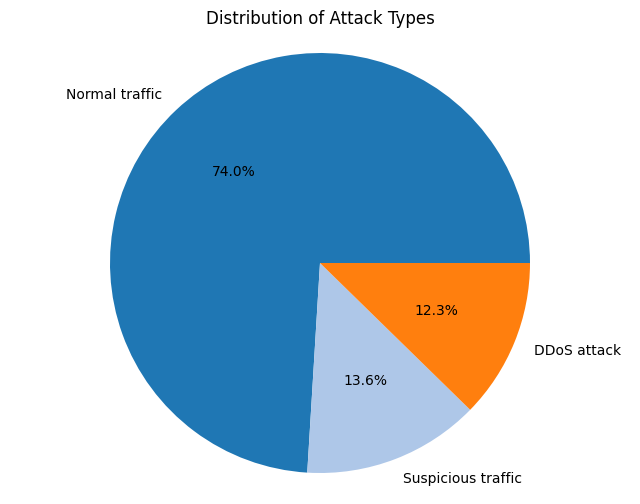

In [124]:
# see how many records are in different classes
value_counts = vector_df['Type'].value_counts()
labels = value_counts.index
print(value_counts)

# Plot
plt.figure(figsize=(8, 6))
plt.pie(value_counts.values, labels = value_counts.index,  autopct='%1.1f%%', colors = plt.cm.tab20.colors)
plt.axis('equal')
plt.title("Distribution of Attack Types")

plt.show()

## Attack labels

In [126]:
# see how many records are with different attack codes of not normal traffic
value_counts = vector_df['Attack code'].value_counts()
print(value_counts)

High volume traffic                                   206755
Suspicious traffic                                     36340
Generic UDP                                             7051
NTP                                                     1150
Suspicious traffic, CLDAP                                412
DNS                                                      395
CLDAP                                                    236
DNS, SNMP                                                157
CLDAP, High volume traffic                               115
SSDP                                                      91
Suspicious traffic, NTP                                   84
NTP, High volume traffic                                  66
DNS, SNMP, High volume traffic                            36
SNMP, High volume traffic                                 31
NTP, RDP                                                  27
NTP, SSDP                                                 18
DNS, High volume traffic

In [127]:
# there are multiple labels on some attacks
# get all the labels
attack_labels_mixed = list(value_counts.index)
attack_labels = []
for mixed_label in attack_labels_mixed:
  for label in mixed_label.split(','):
    attack_labels.append(label.strip())
# get the distinct labels
attack_labels = list(set(attack_labels))
attack_labels

['DNS',
 'High volume traffic',
 'Sentinel',
 'IPv4 fragmentation',
 'RPC',
 'SYN Attack',
 'NTP',
 'Suspicious traffic',
 'Generic UDP',
 'CLDAP',
 'RDP',
 'SNMP',
 'CoAP',
 'TCP Anomaly',
 'ACK Attack',
 'SSDP']

In [132]:
# count attacks for each label
label_count = {}
for label in attack_labels:
  count = vector_df['Attack code'].str.contains(label, case=False).sum()
  label_count[label] = count

# add all attack count
label_count['All attacks'] = len(vector_df)

# order the dict by frequency
label_count = dict(sorted(label_count.items(),key=lambda item: item[1], reverse = True))

for l, c in label_count.items():
  print(f"{l} : {c}")

All attacks : 253038
High volume traffic : 207018
Suspicious traffic : 36836
Generic UDP : 7052
NTP : 1358
CLDAP : 763
DNS : 613
SNMP : 234
SSDP : 113
RDP : 32
TCP Anomaly : 12
IPv4 fragmentation : 10
CoAP : 9
SYN Attack : 6
Sentinel : 5
ACK Attack : 4
RPC : 1


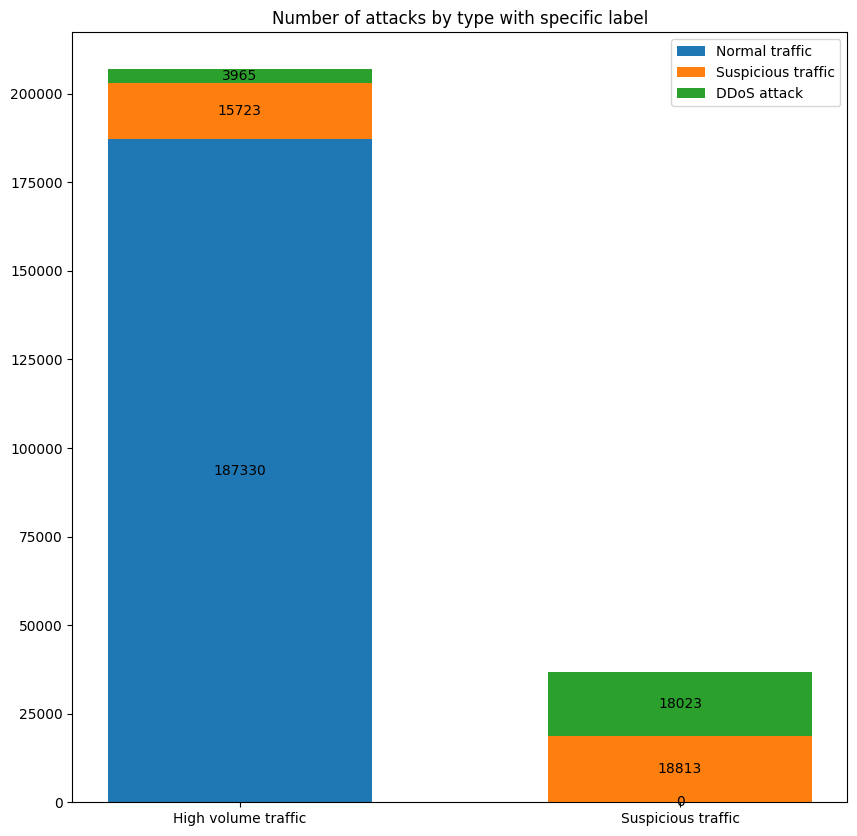

In [133]:
# lets check the class distribution for each label
# high volume and suspicious traffic are the most frequent lets check them seperately

# get the frequency of each class
attack_labels_to_plot = ('High volume traffic', 'Suspicious traffic')
num_attacks_by_type = {label: [] for label in labels}

for attack_label in attack_labels_to_plot:
  for k, _ in num_attacks_by_type.items():
    attack_label_df = vector_df[(vector_df['Attack code'].str.contains(attack_label, case=False))
                                & (vector_df['Type'] == k)]
    num_attacks_by_type[k].append(len(attack_label_df))

num_attacks_by_type

# plot it on a barplot
width = 0.6  # the width of the bars

fig, ax = plt.subplots(figsize=(10,10))
bottom = np.zeros(len(attack_labels_to_plot))

for label, count in num_attacks_by_type.items():
    p = ax.bar(attack_labels_to_plot, count, width, label=label, bottom=bottom)
    bottom += count

    ax.bar_label(p, label_type='center')

ax.set_title('Number of attacks by type with specific label')
ax.legend()

plt.show()

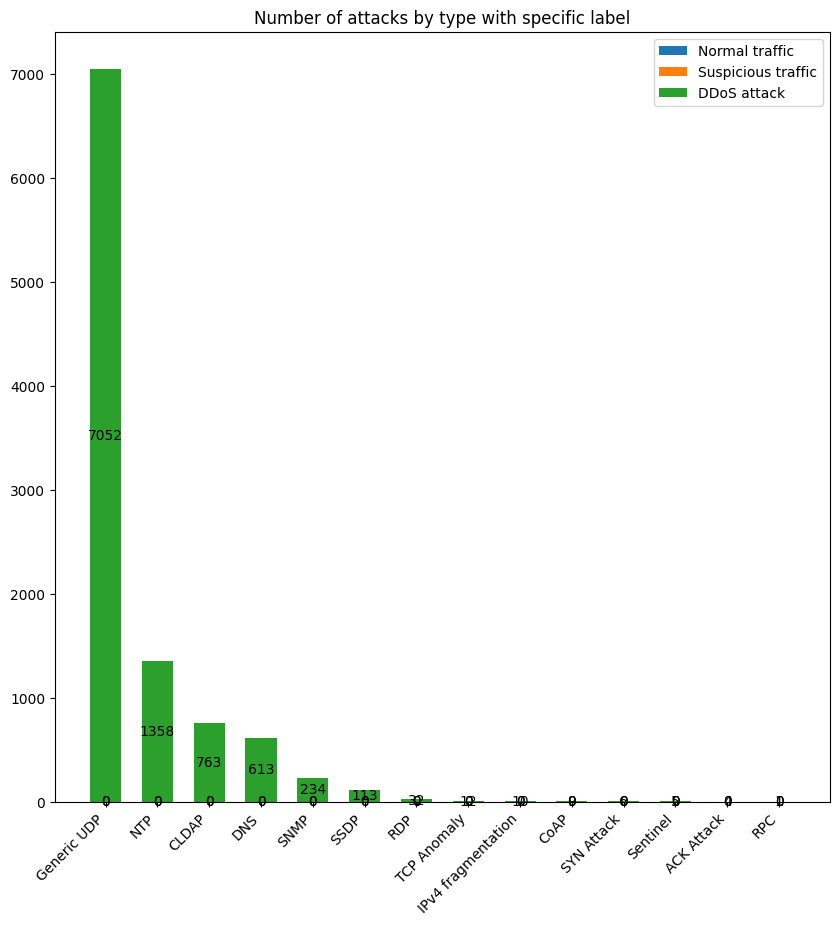

In [134]:
# check for the other labels
# lets check the class distribution for each label
# high volume and suspicious traffic are the most frequent lets check them seperately

# get the frequency of each class
attack_labels_to_plot = list(label_count.keys())[3:]
num_attacks_by_type = {label: [] for label in labels}

for attack_label in attack_labels_to_plot:
  for k, _ in num_attacks_by_type.items():
    attack_label_df = vector_df[(vector_df['Attack code'].str.contains(attack_label, case=False))
                                & (vector_df['Type'] == k)]
    num_attacks_by_type[k].append(len(attack_label_df))

num_attacks_by_type

# plot it on a barplot
width = 0.6  # the width of the bars

fig, ax = plt.subplots(figsize=(10,10))
bottom = np.zeros(len(attack_labels_to_plot))

for label, count in num_attacks_by_type.items():
    p = ax.bar(attack_labels_to_plot, count, width, label=label, bottom=bottom)
    bottom += count

    ax.bar_label(p, label_type='center')

ax.set_title('Number of attacks by type with specific label')
ax.legend()
plt.xticks(rotation=45, ha='right')
plt.show()

## Numerical values analysis

In [131]:
# the number of unique values of each column
vector_df.nunique()

Attack ID            84339
Detect count          5300
Card                     1
Victim IP            14127
Port number          28936
Attack code             32
Significant flag         2
Packet speed          3504
Data speed             656
Avg packet len        1276
Source IP count       1029
Time                213952
Type                     3
dtype: int64

## Port number

In [135]:
# Most frequent ports by label
for label in labels:
  print(f"Most frequent ports for {label}")
  print("port \t count")
  vc = vector_df[vector_df['Type'] == label]['Port number'].value_counts()
  print(vc[:5])
  print(f"There a {len(vc)} number of different ports for {label}")

Most frequent ports for Normal traffic
port 	 count
0        27818
4500     23645
80       15223
443      11917
60645     7857
Name: Port number, dtype: int64
There a 27020 number of different ports for Normal traffic
Most frequent ports for Suspicious traffic
port 	 count
63396    4922
51413    3748
64376    1877
34863    1088
0        1070
Name: Port number, dtype: int64
There a 6818 number of different ports for Suspicious traffic
Most frequent ports for DDoS attack
port 	 count
51413    16997
53        6642
51671     2990
0         1615
443       1098
Name: Port number, dtype: int64
There a 118 number of different ports for DDoS attack


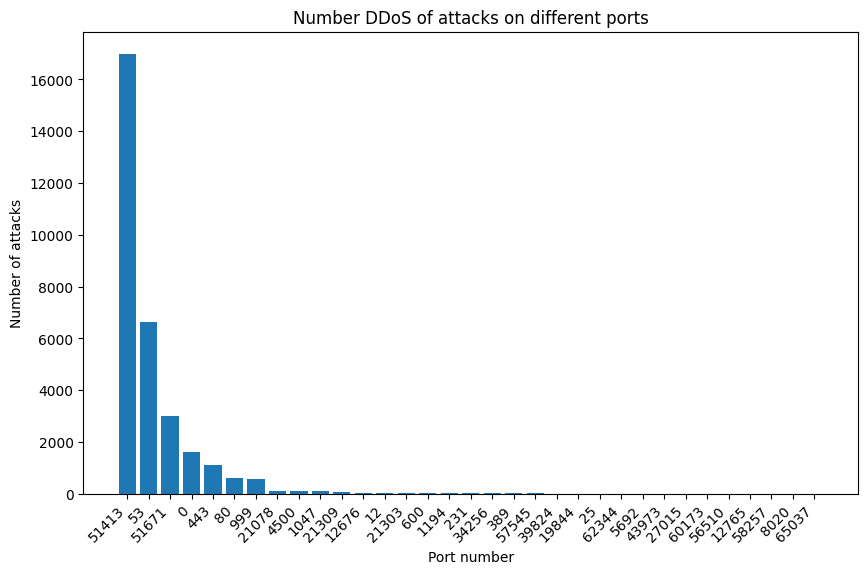

In [136]:
# create histogram for ports for ddos attacks with more than 1 attack
vc = vector_df[vector_df['Type'] == 'DDoS attack']['Port number'].value_counts()

plt.figure(figsize=(10,6))
plt.bar(np.arange(0, len(vc[vc > 1]), 1), vc[vc > 1].values, label = vc[vc>1].index)
plt.title('Number DDoS of attacks on different ports')
plt.xlabel('Port number')
plt.ylabel('Number of attacks')
plt.xticks(np.arange(0, len(vc[vc > 1]), 1), vc[vc > 1].index, rotation=45, ha='right')
plt.show()


In [139]:
vc = vector_df[vector_df['Port number'] == 51671]['Type'].value_counts().sort_index()
vc

DDoS attack       2990
Normal traffic       4
Name: Type, dtype: int64

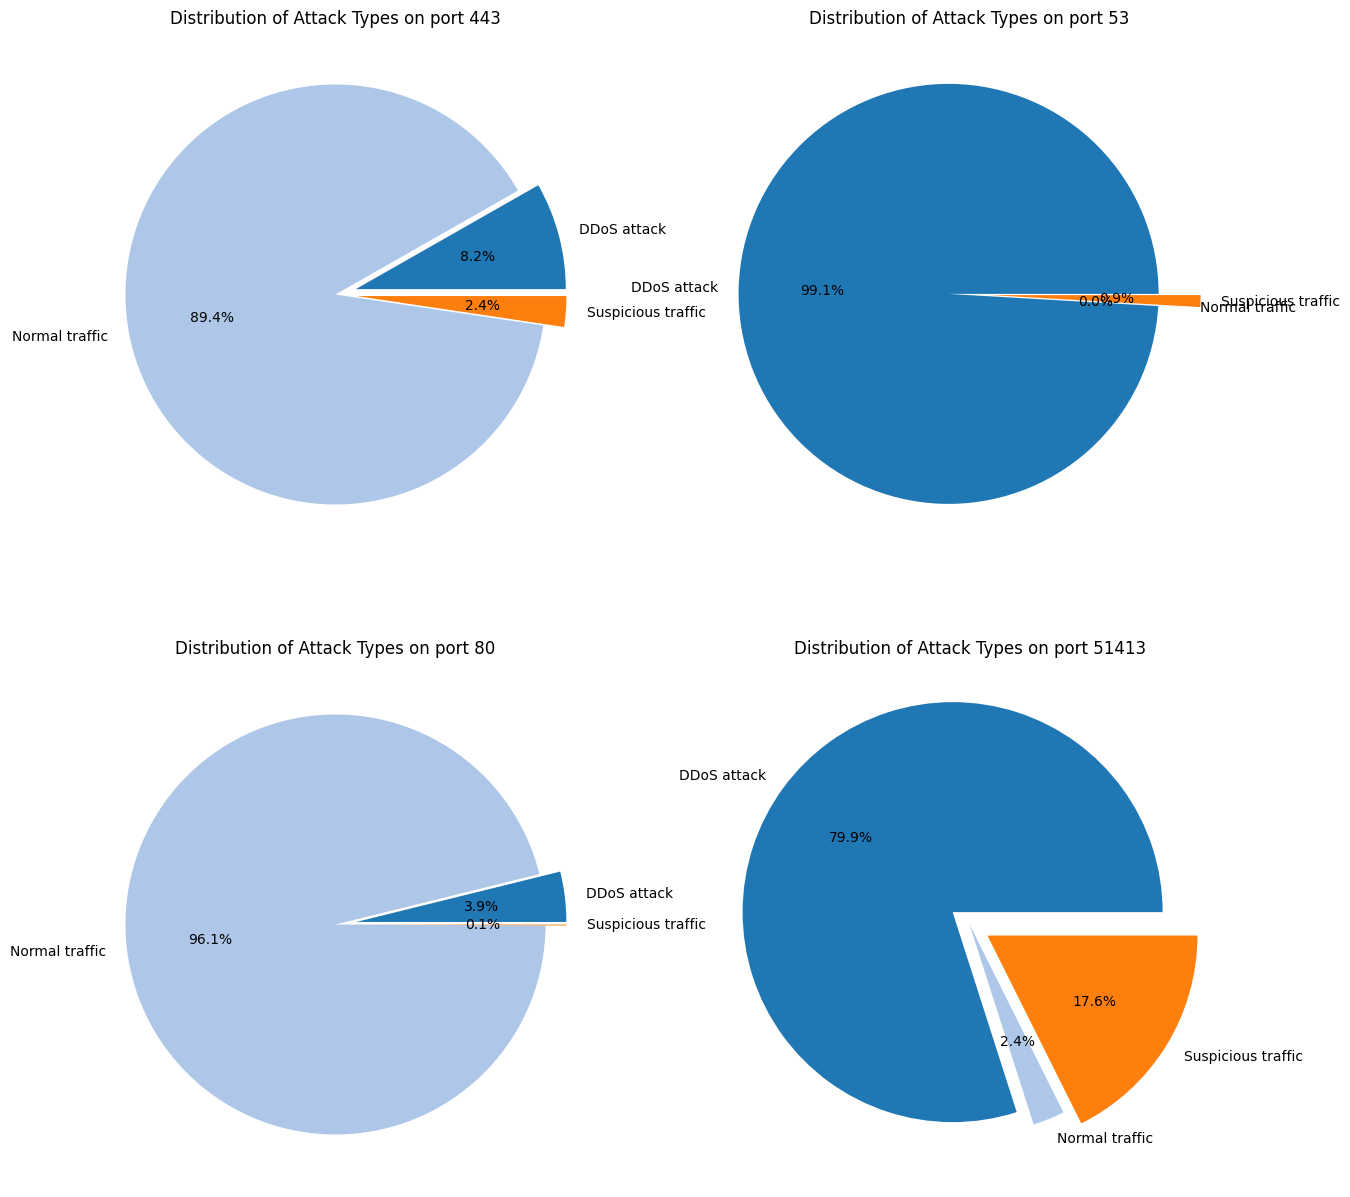

In [140]:
special_ports = [443, 53, 80, 51413]

fig, ax = plt.subplots(2,2, figsize=(15, 15))

for idx, port in enumerate(special_ports):
  vc = vector_df[vector_df['Port number'] == port]['Type'].value_counts().sort_index()
  explode = (0.1, 0, 0.1)

  ax[idx//2][idx%2].pie(vc.values, labels = vc.index,  autopct='%1.1f%%', colors = plt.cm.tab20.colors, explode = explode)
  ax[idx//2][idx%2].set_title(f"Distribution of Attack Types on port {port}")



## Packet speed, Data speed, Avg packet len, Source IP count

<ipython-input-146-d2af329cf88d>:25: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  legend_handles = [plt.Rectangle((0,0), 1, 1, color=color, edgecolor='black') for color in colors]


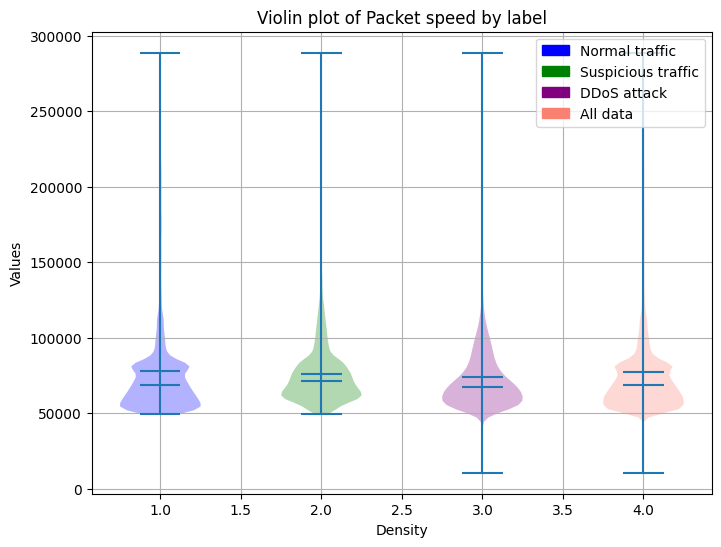

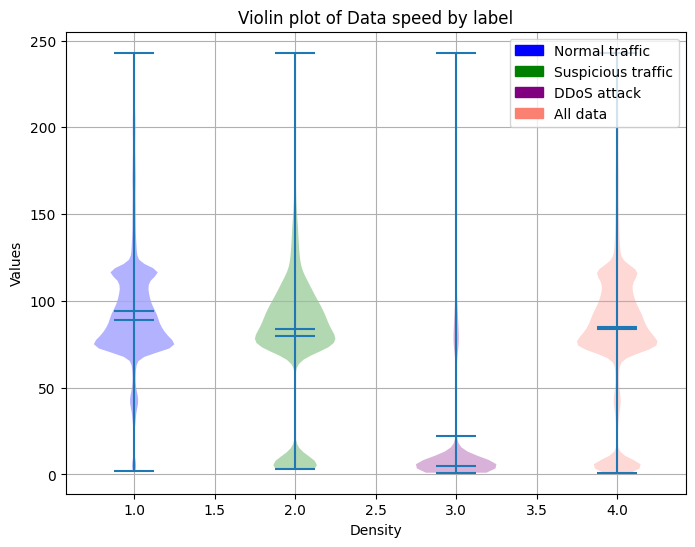

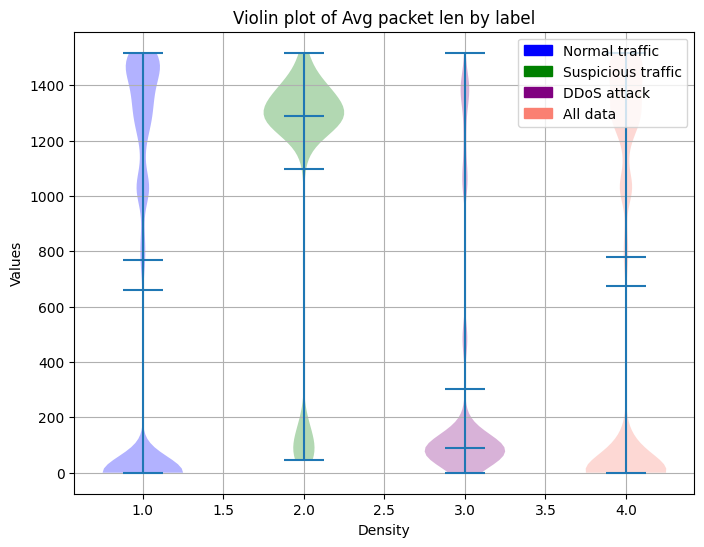

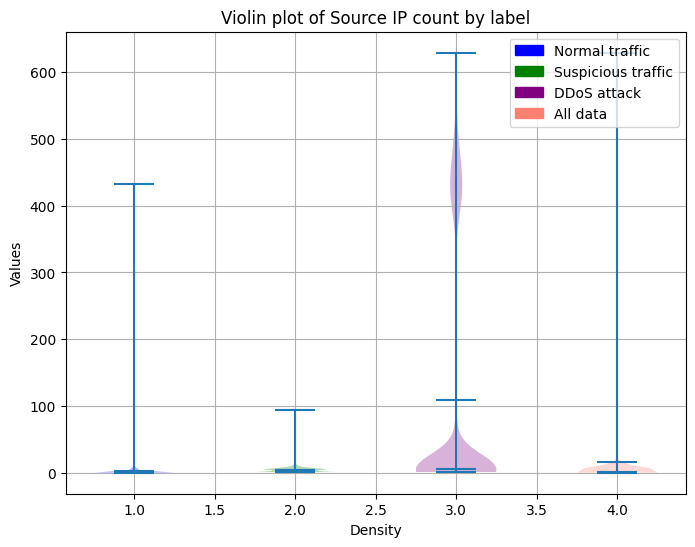

In [150]:
columns_to_plot = ['Packet speed', 'Data speed', 'Avg packet len', 'Source IP count']

for col in columns_to_plot:
  zscores = calculate_zscores(vector_df, col)
  create_violin_plots(vector_df, col, zscores, threshold = 3)